In [165]:
chrom = '16'
family_sizes = [3, 4, 5]
phase_dir = '../sherlock_phased_ssc'
data_dir = '../split_gen_ssc'

In [166]:
# Pull chrom length from cytogenetic coordinates
chrom_length = 0
xticks, xticklabels = [], []
with open('../data/cytoBand.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])
            chrom_length = max(chrom_length, int(pieces[1]), int(pieces[2]))
print('Chrom length', chrom_length)
    
# pull positions that appear as deletion start/endpoints
snp_positions = set([1, chrom_length])
for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as phasef:
        next(phasef) # skip header
        
        for line in phasef:
            pieces = line.strip().split('\t')
            start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
            snp_positions.add(start_pos)
            snp_positions.add(end_pos)
            
snp_positions = np.asarray(sorted(snp_positions))
pos_to_index = dict([(x, i) for i, x in enumerate(snp_positions)])
n = snp_positions.shape[0]
print('n', n)

Chrom length 90354753
n 32814


In [167]:
from collections import Counter

# sample_ids
sample_ids = []
parent_ids = set()
for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as famf:
        next(famf) # skip header
        for line in famf:
            individuals = line.strip().split('\t')[1:(1+j)]
    
            parent_ids.update(individuals[:2])
            sample_ids.extend(individuals)
            
# Remove individuals from multiple families
appearances = Counter(sample_ids)
print('Removing individuals in multiple families', len([k for k, v in appearances.items() if v>1]))
sample_ids = [x for x in sample_ids if appearances[x] == 1]

# map sample ids to index
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])
parent_indices = [i for i, x in enumerate(sample_ids) if x in parent_ids]
child_indices = [i for i, x in enumerate(sample_ids) if x not in parent_ids]
m = len(sample_id_to_index)
print('m', m, 'parents', len(parent_indices), 'children', len(child_indices))

Removing individuals in multiple families 0
m 2073 parents 1038 children 1035


In [168]:
from collections import defaultdict

# load deletions along with inherited/not inherited counts
deletions = np.zeros((m, n), dtype=int)-1
inherited = np.zeros((max(family_sizes)-1, n), dtype=int)
not_inherited = np.zeros((max(family_sizes)-1, n), dtype=int)

for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as famf, \
    open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as phasef:
        next(famf) # skip header
        next(phasef) # skip header
        
        fam_pieces = (None,)
        
        for line in phasef:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [None if x == '*' else int(x) for x in pieces[1:(1+(j*2))]]
            del_state = [0 if x is None else x for x in inheritance_state[:4]]
            start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
            start_index, end_index = pos_to_index[start_pos], pos_to_index[end_pos]
            
            # make sure we're on the right family
            while family_key != fam_pieces[0]:
                fam_pieces = next(famf).strip().split('\t')
                fam_individuals = fam_pieces[1:(1+j)]
               
            if fam_individuals[0] in sample_id_to_index:
                deletions[sample_id_to_index[fam_individuals[0]], start_index:(end_index+1)] = sum(del_state[:2])
            if fam_individuals[1] in sample_id_to_index:
                deletions[sample_id_to_index[fam_individuals[1]], start_index:(end_index+1)] = sum(del_state[2:4])
            
            par_inh = [0, 0, 0, 0]
            for k, child_id in enumerate(fam_individuals[2:]):
                mat, pat = inheritance_state[(4+(2*k)):(6+(2*k))]
                if mat is not None and pat is not None:
                    if child_id in sample_id_to_index:
                        deletions[sample_id_to_index[child_id], start_index:(end_index+1)] = (del_state[mat]+del_state[2+pat])
                    par_inh[mat] += 1
                    par_inh[2+pat] += 1
                elif (mat is None) and (pat is not None) and (del_state[0] == del_state[1]):
                    if child_id in sample_id_to_index:
                        deletions[sample_id_to_index[child_id], start_index:(end_index+1)] = (del_state[0]+del_state[2+pat])
                    par_inh[2+pat] += 1
                elif (pat is None) and (mat is not None) and (del_state[2] == del_state[3]):
                    if child_id in sample_id_to_index:
                        deletions[sample_id_to_index[child_id], start_index:(end_index+1)] = (del_state[mat]+del_state[2])
                    par_inh[mat] += 1
                elif (del_state[0] == del_state[1]) and (del_state[2] == del_state[3]):
                    if child_id in sample_id_to_index:
                        deletions[sample_id_to_index[child_id], start_index:(end_index+1)] = (del_state[0]+del_state[2])
                    
            not_inherited[par_inh[0]+par_inh[1], start_index:(end_index+1)] += (int(par_inh[0]==0) + int(par_inh[1]==0))
            inherited[par_inh[0]+par_inh[1], start_index:(end_index+1)] += (int(par_inh[0]!=0) + int(par_inh[1]!=0))
            
            not_inherited[par_inh[2]+par_inh[3], start_index:(end_index+1)] += (int(par_inh[2]==0) + int(par_inh[3]==0))
            inherited[par_inh[2]+par_inh[3], start_index:(end_index+1)] += (int(par_inh[2]!=0) + int(par_inh[3]!=0))  
            

In [169]:
# fix up missing deletions where we can
print('Percent missing', np.sum(deletions==-1)/(deletions.shape[0]*deletions.shape[1]))

# extend first and last calls to end
first_nonmissing = np.argmax(deletions != -1, axis=1)
last_nonmissing = np.argmax(np.flip(deletions, axis=1) != -1, axis=1)
for i, (fnm, lnm) in enumerate(zip(first_nonmissing, last_nonmissing)):
    deletions[i, 0:fnm] = 0
    deletions[i, (-1-lnm):n] = 0
print('Inferred ends, Percent missing', np.sum(deletions==-1)/(deletions.shape[0]*deletions.shape[1]))


miss_start_x, miss_start_y = np.where((deletions[:, :-1] != -1) & (deletions[:, 1:] == -1))
miss_end_x, miss_end_y = np.where((deletions[:, :-1] == -1) & (deletions[:, 1:] != -1))

print('start and end xs should be equal', np.array_equal(miss_start_x, miss_end_x))
for i, start, end in zip(miss_start_x, miss_start_y, miss_end_y):
    if deletions[i, start] == deletions[i, end+1]:
        #print(i, start, end+1, deletions[i, start], deletions[i, end+1])
        deletions[i, (start+1):(end+1)] = deletions[i, start]
print('Inferred intermediate missing, Percent missing', np.sum(deletions==-1)/(deletions.shape[0]*deletions.shape[1]))

Percent missing 0.0129882469012
Inferred ends, Percent missing 0.0128934560217
start and end xs should be equal True
Inferred intermediate missing, Percent missing 0.00459557885812


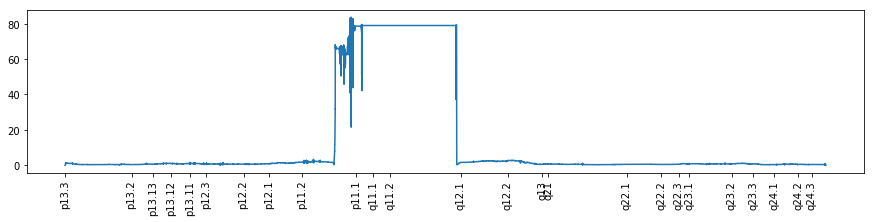

In [170]:
from scipy.stats import binom
import matplotlib.pyplot as plt

# Remove deletions in tricky regions
pvalues = np.zeros((n,))
for i in range(n):
    for j in range(1, max(family_sizes)-1):
        p_not_inherited = pow(0.5, j)
        inh, notinh = inherited[j, i], not_inherited[j, i]
        total = inh+notinh
        if total > 0:
            pvalues[i] = max(pvalues[i], -np.log10(binom.cdf(notinh, total, p_not_inherited)), -np.log10(binom.sf(notinh, total, p_not_inherited)))
    
plt.figure(figsize=(15, 3))
plt.plot(snp_positions, pvalues) 
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.show()

In [171]:
cutoff = 2 + np.log10(n)
print('removing %d indices due to imbalanced transmission' % np.sum(pvalues >= cutoff))
print('%d single deletion positions removed' % np.sum(deletions[:, pvalues >= cutoff]==1))
print('%d double deletion positions removed' % np.sum(deletions[:, pvalues >= cutoff]==2))

deletions = deletions[:, pvalues < cutoff]
snp_positions = snp_positions[pvalues < cutoff]
print('Percent missing', np.sum(deletions==-1)/(deletions.shape[0]*deletions.shape[1]))

removing 6474 indices due to imbalanced transmission
1149734 single deletion positions removed
1966728 double deletion positions removed
Percent missing 0.00404447975398


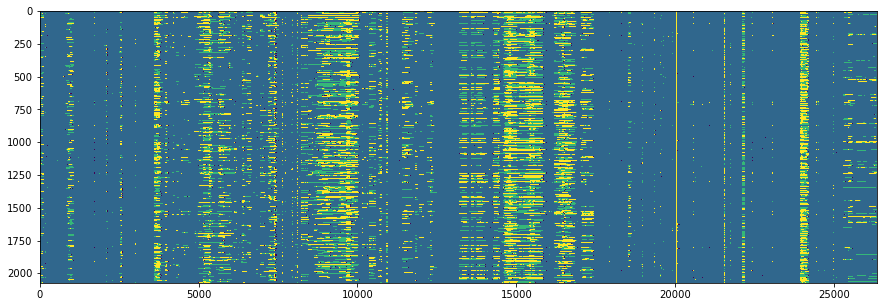

In [172]:
plt.figure(figsize=(15, 5))
plt.imshow(deletions, aspect='auto', vmax=2)
plt.show()

In [173]:
# write to file
np.savez_compressed('%s/chr.%s.deletions' % (phase_dir, chrom), 
                    deletions=deletions, snp_positions=snp_positions, sample_ids=sample_ids)

# load lumpy

In [118]:
import scipy.sparse as sparse
lumpy_d = sparse.load_npz('lumpy_svs/chrom%s_deletions.npz' % chrom).A
lumpy_positions = np.load('lumpy_svs/chrom%s_positions.npy' % chrom)

In [111]:
samples_in_both = np.where((np.sum(lumpy_d != 0, axis=1)>0) & (np.sum(deletions!=-1, axis=1)>0))[0]
print(samples_in_both.shape)

(1807,)


In [141]:
mismatch = np.where(lumpy_d[samples_in_both, :-1] != lumpy_d[samples_in_both, 1:])
lumpy_ind = np.unique(mismatch[1])
lumpy_important = lumpy_positions[lumpy_ind]

In [136]:
merged_positions = sorted(set(snp_positions.tolist() + lumpy_important.tolist()))
pos_to_index = dict([(x, i) for i, x in enumerate(merged_positions)])
print(len(pos_to_index))

127546


In [137]:
my_merged_d = np.zeros((samples_in_both.shape[0], len(merged_positions)))-1
my_merged_d[:, [pos_to_index[p] for p in snp_positions]] = deletions[samples_in_both, :]

In [142]:
lumpy_merged_d = np.zeros((samples_in_both.shape[0], len(merged_positions)))-1
lumpy_merged_d[:, [pos_to_index[p] for p in lumpy_important]] = lumpy_d[np.ix_(samples_in_both, lumpy_ind)]

In [143]:
# fix up missing deletions where we can
def clean_up(deletions):
    m, n = deletions.shape
    print('Percent missing', np.sum(deletions==-1)/(m*n))

    # extend first and last calls to end
    first_nonmissing = np.argmax(deletions != -1, axis=1)
    last_nonmissing = np.argmax(np.flip(deletions, axis=1) != -1, axis=1)
    print(np.sum(first_nonmissing == 0), np.sum(last_nonmissing==0))
    for i, (fnm, lnm) in enumerate(zip(first_nonmissing, last_nonmissing)):
        deletions[i, 0:fnm] = 0
        deletions[i, (-1-lnm):n] = 0
    first_nonmissing = np.argmax(deletions != -1, axis=1)
    last_nonmissing = np.argmax(np.flip(deletions, axis=1) != -1, axis=1)
    print(np.sum(first_nonmissing == 0), np.sum(last_nonmissing==0))
    print('Inferred ends, Percent missing', np.sum(deletions==-1)/(m*n))


    miss_start_x, miss_start_y = np.where((deletions[:, :-1] != -1) & (deletions[:, 1:] == -1))
    miss_end_x, miss_end_y = np.where((deletions[:, :-1] == -1) & (deletions[:, 1:] != -1))

    print('start and end xs should be equal', np.array_equal(miss_start_x, miss_end_x))
    for i, start, end in zip(miss_start_x, miss_start_y, miss_end_y):
        if deletions[i, start] == deletions[i, end+1]:
            #print(i, start, end+1, deletions[i, start], deletions[i, end+1])
            deletions[i, (start+1):(end+1)] = deletions[i, start]
    print('Inferred intermediate missing, Percent missing', np.sum(deletions==-1)/(m*n))
    
clean_up(my_merged_d)
clean_up(lumpy_merged_d)

Percent missing 0.246156359218
1804 1807
1807 1807
Inferred ends, Percent missing 0.244496161941
start and end xs should be equal True
Inferred intermediate missing, Percent missing 0.000344648164134
Percent missing 0.75421416587
0 0
1807 1807
Inferred ends, Percent missing 0.711053267057
start and end xs should be equal True
Inferred intermediate missing, Percent missing 0.00910247679037


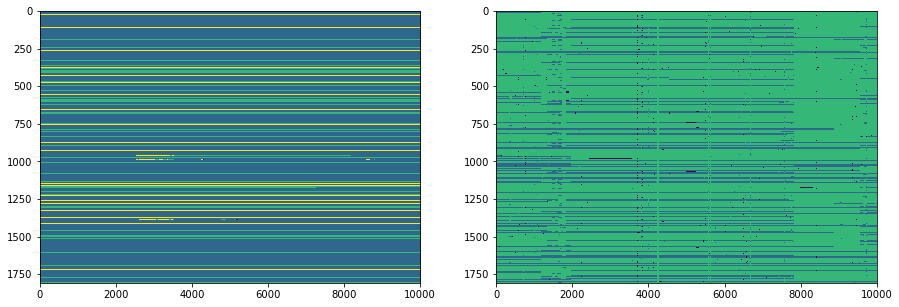

In [145]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(my_merged_d[:, 30000:40000], aspect='auto', vmax=2)
#plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(lumpy_merged_d[:, 30000:40000], aspect='auto', vmax=2)
#plt.colorbar()
plt.show()

# Estimate deletion lengths

In [150]:
del_conserve_lengths = []
del_start_x, del_start_y = np.where((my_merged_d[:, :-1] < 1) & (my_merged_d[:, 1:] >= 1))
del_end_x, del_end_y = np.where((my_merged_d[:, :-1] >= 1) & (my_merged_d[:, 1:] < 1))
print('start and end xs should be equal', np.array_equal(del_start_x, del_end_x))
for i, start, end in zip(del_start_x, del_start_y, del_end_y):
    del_conserve_lengths.append(merged_positions[end] - merged_positions[start])

start and end xs should be equal False


Conserve 4248.0
Full 305.0
Conserve min length -249215768 max length 249219645 num 7790
Best min length -249219709 max length 249219720 num 14277


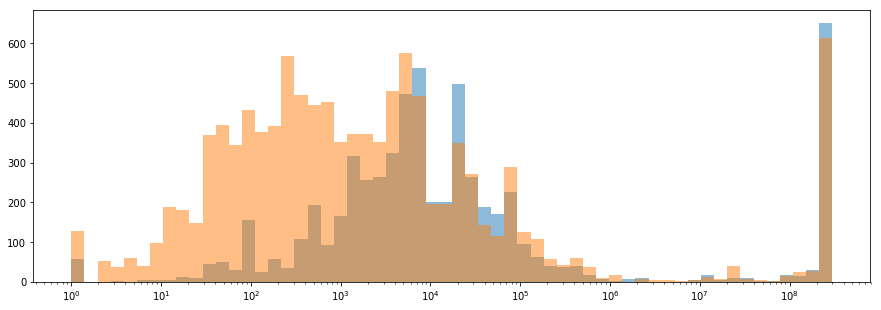

In [151]:
import math

print('Conserve', np.median([x for x in del_conserve_lengths]))
print('Full', np.median([x for x in del_full_lengths]))

plt.figure(figsize=(15, 5))
base = 1.4
max_length = max(del_full_lengths) 
min_length = min(del_full_lengths) 
print('Conserve min length', min(del_conserve_lengths) , 'max length', max(del_conserve_lengths) , 'num', len(del_conserve_lengths))
print('Best min length', min(del_full_lengths) , 'max length', max(del_full_lengths) , 'num', len(del_full_lengths))

plt.hist(del_conserve_lengths, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)
plt.hist(del_full_lengths, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)

plt.gca().set_xscale("log")
plt.show()

In [78]:
del_unknown_endpoints = []
del_direct_endpoints = []

# unknown transitions
del_start_x, del_start_y = np.where((deletions[parent_indices, :-1] != -1) & (deletions[parent_indices, 1:] == -1))
del_end_x, del_end_y = np.where((deletions[parent_indices, :-1] == -1) & (deletions[parent_indices, 1:] != -1))
print('start and end xs should be equal', np.array_equal(del_start_x, del_end_x))
for i, start, end in zip(del_start_x, del_start_y, del_end_y):
    del_unknown_endpoints.append(snp_positions[end+1] - snp_positions[start])
    
# direction transitions
del_trans_x, del_trans_y = np.where((deletions[parent_indices, :-1] == 0) & (deletions[parent_indices, 1:] > 0))
for i, start in zip(del_trans_x, del_trans_y):
    del_direct_endpoints.append(snp_positions[start+1] - snp_positions[start])
    
del_trans_x, del_trans_y = np.where((deletions[parent_indices, :-1] > 0) & (deletions[parent_indices, 1:] == 0))
for i, start in zip(del_trans_x, del_trans_y):
    del_direct_endpoints.append(snp_positions[start+1] - snp_positions[start])

start and end xs should be equal True


Unknown transitions 201.0
Direct transitions 18.0
Transitions 45.0
min length 2 max length 25933318 num 113523
min length 1 max length 25356234 num 182983


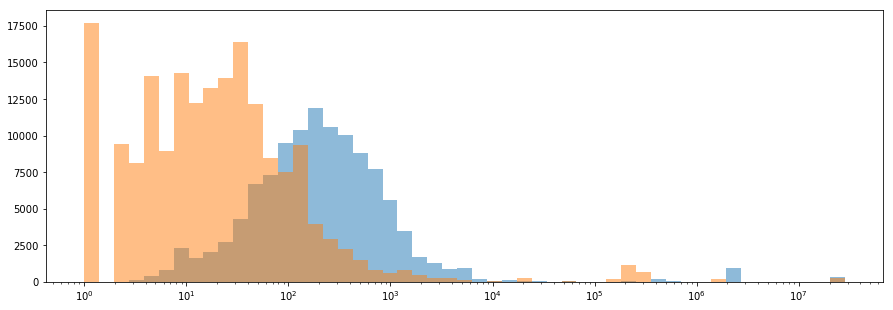

In [79]:
import math

print('Unknown transitions', np.median([x for x in del_unknown_endpoints]))
print('Direct transitions', np.median([x for x in del_direct_endpoints]))
print('Transitions', np.median([x for x in del_direct_endpoints+del_unknown_endpoints]))

plt.figure(figsize=(15, 5))
base = 1.4
max_length = max(del_unknown_endpoints) 
min_length = min(del_unknown_endpoints) 
print('min length', min(del_unknown_endpoints) , 'max length', max(del_unknown_endpoints) , 'num', len(del_unknown_endpoints))
print('min length', min(del_direct_endpoints) , 'max length', max(del_direct_endpoints) , 'num', len(del_direct_endpoints))

plt.hist(del_unknown_endpoints, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)
plt.hist(del_direct_endpoints, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)

plt.gca().set_xscale("log")
plt.show()

In [155]:
from collections import defaultdict

family_sizes = [3, 4, 5, 6, 7]
phase_dir = 'sherlock_phased'
data_dir = 'split_gen'

# sample_ids
sample_file = 'split_gen/chr.22.gen.samples.txt'
#sample_file = 'split_gen/chr.%s.gen.samples.txt' % ('X' if chrom.startswith('PAR') else chrom)
with open(sample_file, 'r') as f:
    sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])
m = max(sample_id_to_index.values())+1
print('m', m)

dels = []
snppos = []

for chrom in range(1, 23):
    chrom = str(chrom)
    print(chrom)
    
    # snp positions
    clean_file = '%s/clean_indices_%s.txt' % (data_dir, 'X' if chrom.startswith('PAR') else chrom) 
    snp_positions = []
    with open(clean_file, 'r') as f:
        for i, line in enumerate(f):
            index, position = line.strip().split('\t')
            snp_positions.append(int(position))
    snp_positions = np.array(snp_positions)
    print('snp pos', snp_positions.shape)

    # pull positions that appear as deletion start/endpoints
    important_indices = set([0, len(snp_positions)-1])
    for j in family_sizes:
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as phasef:
            next(phasef) # skip header

            for line in phasef:
                pieces = line.strip().split('\t')
                start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(1+(j*2)):(5+(j*2))]]
                important_indices.add(start_index)
                important_indices.add(end_index)

    important_indices = sorted(important_indices)
    snp_positions = snp_positions[important_indices]
    old_index_to_new_index = dict([(x, i) for i, x in enumerate(important_indices)])
    n = snp_positions.shape[0]
    print('n', n)

    deletions = np.zeros((m, n), dtype=int)-1
    inherited = np.zeros((max(family_sizes)-1, n), dtype=int)
    not_inherited = np.zeros((max(family_sizes)-1, n), dtype=int)

    # load deletions
    for j in family_sizes:
        with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as famf, \
        open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as phasef:
            next(famf) # skip header
            next(phasef) # skip header

            fam_pieces = next(famf).strip().split('\t')
            fam_individuals = fam_pieces[1:(1+j)]
            fam_indices = [sample_id_to_index[ind] for ind in fam_individuals]

            for line in phasef:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                inheritance_state = [None if x == '*' else int(x) for x in pieces[1:(1+(j*2))]]
                del_state = [0 if x is None else x for x in inheritance_state[:4]]
                start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(1+(j*2)):(5+(j*2))]]
                start_index, end_index = old_index_to_new_index[start_index], old_index_to_new_index[end_index]

                # make sure we're on the right family
                while family_key != fam_pieces[0]:
                    fam_pieces = next(famf).strip().split('\t')
                    fam_individuals = fam_pieces[1:(1+j)]
                    fam_indices = [sample_id_to_index[ind] for ind in fam_individuals]

                deletions[fam_indices[0], start_index:(end_index+1)] = sum(del_state[:2])
                deletions[fam_indices[1], start_index:(end_index+1)] = sum(del_state[2:4])

                par_inh = [0, 0, 0, 0]
                for k, child_index in enumerate(fam_indices[2:]):
                    mat, pat = inheritance_state[(4+(2*k)):(6+(2*k))]
                    if mat is not None and pat is not None:
                        deletions[child_index, start_index:(end_index+1)] = (del_state[mat]+del_state[2+pat])
                        par_inh[mat] += 1
                        par_inh[2+pat] += 1
                    elif (mat is None) and (pat is not None) and (del_state[0] == del_state[1]):
                        deletions[child_index, start_index:(end_index+1)] = (del_state[0]+del_state[2+pat])
                        par_inh[2+pat] += 1
                    elif (pat is None) and (mat is not None) and (del_state[2] == del_state[3]):
                        deletions[child_index, start_index:(end_index+1)] = (del_state[mat]+del_state[2])
                        par_inh[mat] += 1
                    elif (del_state[0] == del_state[1]) and (del_state[2] == del_state[3]):
                        deletions[child_index, start_index:(end_index+1)] = (del_state[0]+del_state[2])

                not_inherited[par_inh[0]+par_inh[1], start_index:(end_index+1)] += (int(par_inh[0]==0) + int(par_inh[1]==0))
                inherited[par_inh[0]+par_inh[1], start_index:(end_index+1)] += (int(par_inh[0]!=0) + int(par_inh[1]!=0))

                not_inherited[par_inh[2]+par_inh[3], start_index:(end_index+1)] += (int(par_inh[2]==0) + int(par_inh[3]==0))
                inherited[par_inh[2]+par_inh[3], start_index:(end_index+1)] += (int(par_inh[2]!=0) + int(par_inh[3]!=0))  

    print('deletions loaded')
    
    # Remove deletions in tricky regions
    pvalues = np.ones((n,))
    for i in range(n):
        actual = []
        expected = []
        for j in range(1, inherited.shape[0]):
            p_not_inherited = pow(0.5, j)
            inh, notinh = inherited[j, i], not_inherited[j, i]
            total = inh+notinh
            if total != 0:
                actual.extend([inh, notinh])
                expected.extend([total*(1-p_not_inherited), total*p_not_inherited])

        pvalues[i] = chisquare(actual, expected)[1]
    print('pvalues calculated')
    
    region_switch = np.where((pvalues[:-1] <= 0.01/n) != (pvalues[1:] <= 0.01/n))[0]
    with open('%s/chr.%d.bad_regions.txt' % (phase_dir, chrom), 'w+') as f:
        if pvalues[0] <= 0.01/n:
            start = 1
        else:
            start = region_switch[0]
            region_switch = region_switch[1:]
            
        for i in range(0, region_switch.shape[0], 2):
            f.write('%d\t%d\n' % (start, snp_positions[region_switch[i]]))
            start = snp_positions[region_switch[i+1]]

m 4610
1
snp pos (5734717,)
n 133909
deletions loaded
pvalues calculated


FileNotFoundError: [Errno 2] No such file or directory: 'phase_dir/chr.%d.bad_regions.txt'